Install the required packages for this project.

In [9]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

Define the ticker symbol and the date range, and retrieve the stock data. I have considered the data for Apple Inc. You can customize this based on the company you are evaluating.  

In [10]:
ticker = 'AAPL'  # Apple Inc.
start_date = '2010-01-01'
end_date = pd.to_datetime('today').strftime('%Y-%m-%d')
df_yf = yf.download(ticker, start=start_date, end=end_date) # Retrieve stock data

The time frame for the data that we assessing can be calculated as follows. 

In [24]:
n_years_float = (df_yf.index.max() - df_yf.index.min()).days / 365
n_years = int(n_years_float)
print(f"Number of Years: {n_years_float:.2f}")

Number of Years: 14.10


First, we calculate daily returns which is the percentage change between the current and previous day's closing prices, providing a measure of the daily stock price movement.

In [12]:
df_yf['Returns'] = df_yf['Close'].pct_change()

Next, we calculate the daily volatility which helps to assess the degree of variation in the daily returns, providing insights into the stock's price stability over time. We compute the daily volatility by applying the rolling standard deviation with a window of 20 days to the daily returns. I have also calculated annualized volatility.

In [27]:
df_yf['Volatility'] = df_yf['Returns'].rolling(window=20).std()

annualized_volatility = df_yf['Returns'].std() * np.sqrt(252)

Then, calculate daily moving averages (MA) for the stock's closing prices. Moving averages smooth out price data over a specified period, helping identify trends and potential reversal points in the stock's price. I have calculated 50-day moving average and 200-day moving average. 

In [14]:
df_yf['MA_50'] = df_yf['Close'].rolling(window=50).mean()
df_yf['MA_200'] = df_yf['Close'].rolling(window=200).mean()

Now, that we have all the values of stock price, moving averages, and volatility, we can , we can plot them.

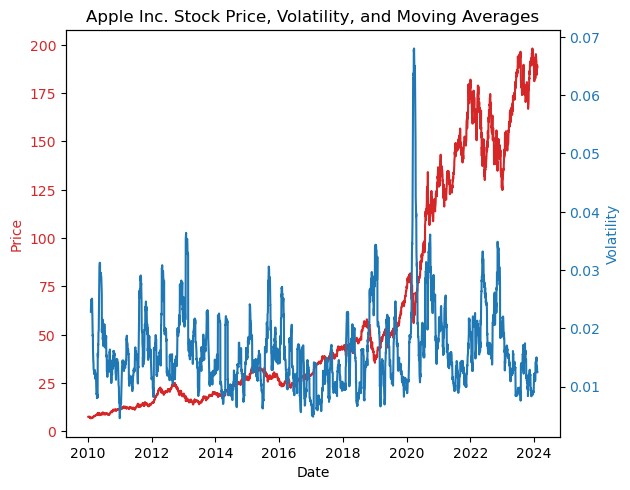

In [25]:
fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Date')
ax1.set_ylabel('Price', color=color)
ax1.plot(df_yf['Close'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Volatility', color=color)  # we already handled the x-label with ax1
ax2.plot(df_yf['Volatility'], color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise, the right y-label is slightly clipped
plt.title('Apple Inc. Stock Price, Volatility, and Moving Averages')
plt.show()

We can also calculate Sharpe ratio i.e., performance of the investment relative to its risk. For this, we take into account the returns and years on an annual basis. I have assumed that a year has 252 trading days.

In [26]:
total_return = (df_yf['Close'][-1] / df_yf['Close'][0]) - 1
n_years = (df_yf.index.max() - df_yf.index.min()).days / 365
ret_comp = (1 + total_return) ** (1 / n_years / 252) - 1
sharpe_ratio = df_yf['Returns'].mean() / df_yf['Returns'].std() * np.sqrt(252)

I have then plotted the Sharpe ratio and daily volatility to assess the short term performance. If your aim is to asses longer-term measure of risk and return, then annualized volatility (calculated above) would be more appropriate.

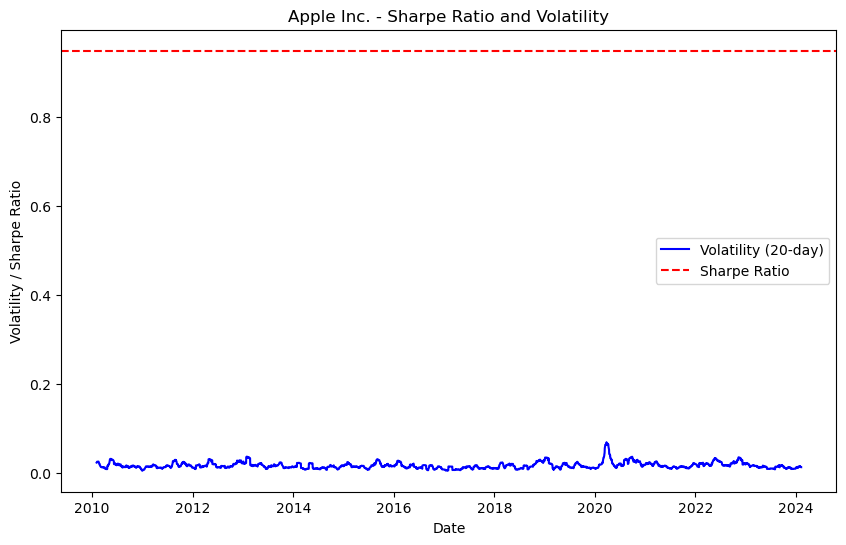

In [30]:
plt.figure(figsize=(10, 6))
plt.plot(df_yf.index, df_yf['Returns'].rolling(window=20).std(), label='Volatility (20-day)', color='blue')
plt.axhline(sharpe_ratio, linestyle='--', color='red', label='Sharpe Ratio')
plt.title('Apple Inc. - Sharpe Ratio and Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility / Sharpe Ratio')
plt.legend()
plt.show()

Next, we calculate the maximum drawdown which measures the decline from the peak in the cumulative returns. It is the difference between cumulative returns and the peak, normalized by the peak. The drawdown provides insights into the magnitude of losses relative to previous highs.

In [21]:
cumulative_returns = (1 + df_yf['Returns']).cumprod()
peak = cumulative_returns.cummax()
drawdown = (cumulative_returns - peak) / peak
max_drawdown = drawdown.min()

Plotting the above.

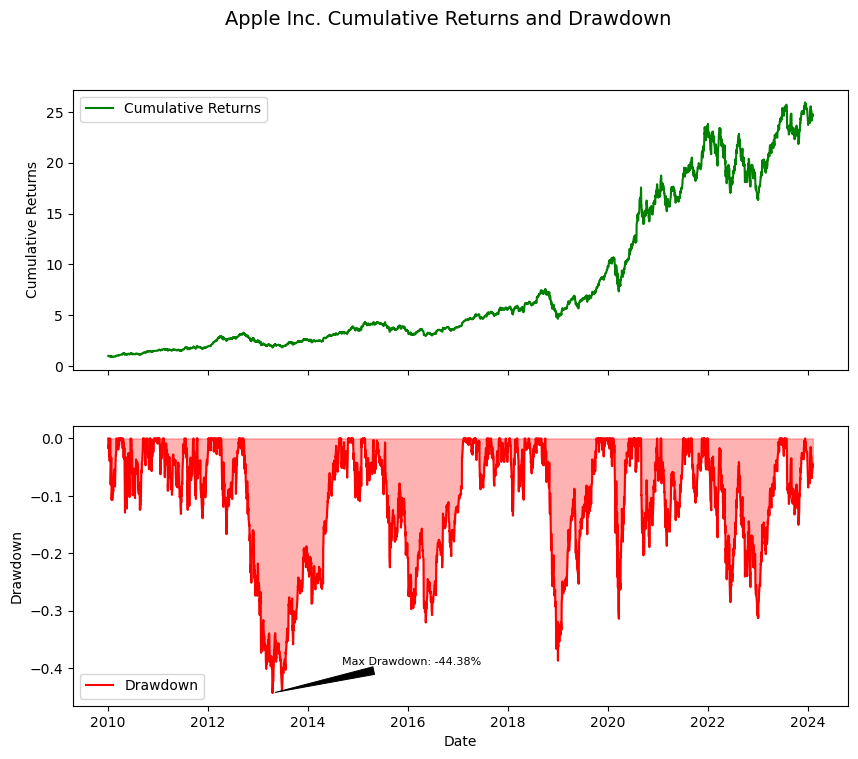

In [31]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
# Plot Cumulative Returns
ax1.plot(df_yf.index, cumulative_returns, label='Cumulative Returns', color='green')
ax1.set_ylabel('Cumulative Returns')
ax1.legend()
# Plot Drawdown
ax2.plot(df_yf.index, drawdown, label='Drawdown', color='red')
ax2.fill_between(df_yf.index, drawdown, color='red', alpha=0.3)
ax2.set_ylabel('Drawdown')
ax2.legend()
# Highlight Maximum Drawdown
ax2.annotate(f'Max Drawdown: {max_drawdown:.2%}', xy=(drawdown.idxmin(), max_drawdown),
             xytext=(50, 20), textcoords='offset points',
             arrowprops=dict(facecolor='black', arrowstyle='wedge,tail_width=0.7', lw=0.7),
             fontsize=8, color='black')
# Set x-axis label
plt.xlabel('Date')
# Show the plot
plt.suptitle('Apple Inc. Cumulative Returns and Drawdown', fontsize=14)
plt.show()